<a href="https://colab.research.google.com/github/kalnikos/Document-Classification-/blob/main/SVM_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Develop a SVM model**


In [16]:
import numpy as np
import pandas as pd
import pickle
from zipfile import ZipFile
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ShuffleSplit

In [2]:
files = "/content/model_data.zip"

with ZipFile(files, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [3]:
## Read the different data parts
path_df = "/content/model_data/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

path_X_train = "/content/model_data/X_train.pickle"
with open(path_X_train, 'rb') as data:
    X_train = pickle.load(data)

path_X_test = "/content/model_data/X_test.pickle"
with open(path_X_test, 'rb') as data:
    X_test = pickle.load(data)

path_y_train = "/content/model_data/y_train.pickle"
with open(path_y_train, 'rb') as data:
    y_train = pickle.load(data)

path_y_test = "/content/model_data/y_test.pickle"
with open(path_y_test, 'rb') as data:
    y_test = pickle.load(data)

In [4]:
print(X_train.shape)
print(X_test.shape)

(1080, 293)
(121, 293)


In [7]:
## Train a SVM model
from sklearn import svm
svc_model =svm.SVC(random_state=42)
svc_model

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [8]:
## Fit the model
svc_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [9]:
## Pedictions
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred = svc_model.predict(X_train)

## Training set Accuracy
print("Training set Accuracy is: ",accuracy_score(y_train, y_pred))

Training set Accuracy is:  0.9925925925925926


In [10]:
## Cross validation scores
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svc_model, X_train, y_train, cv=10, scoring="accuracy")
scores

array([0.87962963, 0.87962963, 0.90740741, 0.83333333, 0.87962963,
       0.94444444, 0.84259259, 0.84259259, 0.89814815, 0.89814815])

## Tune the parameters
### We'll tune the following ones:

### C: Penalty parameter C of the error term.
### kernel: Specifies the kernel type.
### gamma: Kernel coefficient.
### degree: Degree of the polynomial kernel function.

In [11]:
# C
C = [.0001, .001, .01]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
#degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              #'degree': degree,
              'probability': probability
             }

print(random_grid)

{'C': [0.0001, 0.001, 0.01], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'probability': [True]}


In [13]:
# Random search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
random_search = RandomizedSearchCV(estimator=svc_model,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=42)


In [14]:

# Fit the random search model
random_search.fit(X_train, y_train)

print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  5.3min finished


The best hyperparameters from Random Search are:
{'probability': True, 'kernel': 'poly', 'gamma': 100, 'C': 0.001}

The mean accuracy of a model with these hyperparameters is:
0.7287037037037036


In [17]:
# Create the parameter grid based on the results of random search 
C = [.0001, .001, .01, .1]
degree = [3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]



# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .10, random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc_model, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:  5.2min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=42, test_size=0.1, train_size=None),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated...one,
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear'],
                          'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1], 'degree': [3, 4, 5],
                          'kernel': ['poly'], 'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1],
                          'gamma': [1, 10, 100], 'kernel': ['rbf'],
                          'probability':

In [18]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.1, 'kernel': 'linear', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.8395061728395062


In [21]:
best_svc_model = grid_search.best_estimator_
best_svc_model

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [22]:
## Fit the model
best_svc_model.fit(X_train, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [24]:
## Predictions 
y_pred = best_svc_model.predict(X_train)

## Acuraccy
print("Train set Accuracy:",accuracy_score(y_train, y_pred))

Train set Accuracy: 0.8759259259259259


In [25]:
## Test set Accuracy
y_test_pred = best_svc_model.predict(X_test)

print("Test set Accuracy:", accuracy_score(y_test, y_test_pred))

Test set Accuracy: 0.8264462809917356


In [26]:
# Classification report
print("Classification report")
print(classification_report(y_test,y_test_pred))

Classification report
              precision    recall  f1-score   support

           0       0.59      0.81      0.68        16
           1       0.69      0.90      0.78        10
           2       1.00      0.71      0.83        14
           3       0.75      0.86      0.80        14
           4       0.73      0.73      0.73        15
           5       1.00      0.73      0.85        15
           6       1.00      0.91      0.95        23
           7       1.00      0.93      0.96        14

    accuracy                           0.83       121
   macro avg       0.85      0.82      0.82       121
weighted avg       0.86      0.83      0.83       121



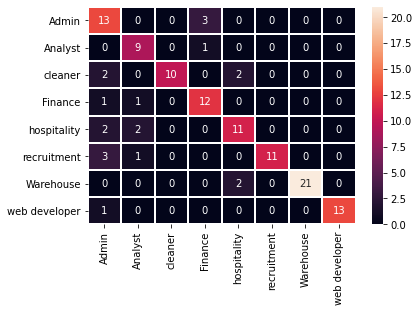

In [27]:
## Confusion matrix
encode = {'Admin':0, 'Analyst':1, 'cleaner':2, 'Finance':3, 'hospitality':4,
       'recruitment':5, 'Warehouse':6, 'web developer':7}
labels = [i for i in encode]
cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)

In [33]:
## Create a data freme with the model train, test set accuracy
D = {
     'Model': 'SVM',
     'Train Set Accuracy': accuracy_score(y_train,best_svc_model.predict(X_train)),
     'Test Set Accuracy': accuracy_score(y_test, y_test_pred)
}

svm_df = pd.DataFrame(D, index=[0])
svm_df

,Model,Train Set Accuracy,Test Set Accuracy
0,SVM,0.875926,0.826446


In [34]:
## Save the model and the dataframe
## Save the model
with open('/content/model_data/best_svm.pickle', 'wb') as output:
    pickle.dump(best_svc_model, output)

## Save the data frame
with open('/content/model_data/svm_df.pickle', 'wb') as output:
  pickle.dump(svm_df, output)